In [1]:
# libraries need for the code
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

# Reading the data 
Alzheimers = pd.read_csv("alzheimers_disease_data.csv")

# removing the DoctorInCharge column - information from this column was not needed, and all of it was redacted
Alzheimers = Alzheimers.drop('DoctorInCharge', axis=1) # axis=1 is the setting to for dropping a column
# removing the PatientID column - information from this column was not needed as it only serves as a numerical identifier 
Alzheimers = Alzheimers.drop('PatientID', axis=1) # axis=1 is the setting to for dropping a column

# Printing a summary of null values per column
print(Alzheimers.isnull().sum())

# removing any of the n/a values
Alzheimers = Alzheimers.dropna()

# showing 10 rows of the dataset after cleaning 
display(Alzheimers.head(10))

Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfulness                0
Diagnosi

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0
5,86,1,1,1,30.626886,0,4.140144,0.211062,1.584922,7.261953,...,5.510144,0,0,9.015686,1,0,0,0,0,0
6,68,0,3,2,38.387622,1,0.646047,9.257695,5.897388,5.477686,...,6.062124,0,0,9.236328,0,0,0,0,1,0
7,75,0,0,1,18.776009,0,13.723826,4.649451,8.341903,4.213210,...,3.401374,0,0,4.517248,1,0,0,0,1,1
8,72,1,1,0,27.833188,0,12.167848,1.531360,6.736882,5.748224,...,7.396061,0,1,0.756232,0,0,1,0,0,0
9,87,0,0,0,35.456302,1,16.028688,6.440773,8.086019,7.551773,...,1.148904,0,1,4.554394,0,0,0,0,0,0


In [2]:
# Cluster Variable Creation
# libraries needed for clusters and scaling
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# numerical stabilizer added to prevent zero division
epsilon = 1e-5 

# CognitiveScore cluster
# averaging the functional cognitive assessments into a singular measuring metric
Alzheimers['CognitiveScore'] = (
    Alzheimers['MMSE'] + 
    Alzheimers['FunctionalAssessment'] + 
    (1 - Alzheimers['MemoryComplaints']) + 
    (1 - Alzheimers['BehavioralProblems']) + 
    Alzheimers['ADL']
) / 5

# standardizing the cognitive average metric with z-score normalization
# levels the score to the same scale pre-PCA
cognitive_features = ['MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL']
X_cognitive = (Alzheimers[cognitive_features] - Alzheimers[cognitive_features].mean()) / Alzheimers[cognitive_features].std()

# PCA is applied 
# reduces standardized features into a singular principal component
# turns the cognitive metric into a singular dimension and summarizes it 
pca = PCA(n_components=1)
Alzheimers['CognitivePCA'] = pca.fit_transform(X_cognitive)

# removes the columns used to make the CognitiveScore cluster from the dataset
# prevents redundancy
Alzheimers = Alzheimers.drop(columns=cognitive_features)

# MetabolicRisk cluster
# factors all associated with metabolic syndrome
# BMI is multiplied by the sum of the other features 
# BMI is multiplied because it acts as an amplifier for the other conditions
# more condtions = higher BMI = overall worse metabolic risk
Alzheimers['MetabolicRisk'] = Alzheimers['BMI'] * (
    Alzheimers['Hypertension'] + 
    Alzheimers['Diabetes'] + 
    Alzheimers['CardiovascularDisease'] + 
    Alzheimers['CholesterolTriglycerides']
)

# removes the columns used to make the MetabolicRisk cluster from the dataset
# prevents redundancy
Alzheimers = Alzheimers.drop(columns=['BMI', 'Hypertension', 'Diabetes', 'CardiovascularDisease', 'CholesterolTriglycerides'], errors='ignore')

# Ratio Clusters
# epsilon prevents zero division and numerical imbalance 
# Cholesterol_Ratio divides bad cholesterol by good cholesterol 
# higher scores = worse level of cholesterol
Alzheimers['Cholesterol_Ratio'] = Alzheimers['CholesterolLDL'] / (Alzheimers['CholesterolHDL'] + epsilon)
# BP_Ratio = blood pressure reading
# measures risk of cardiovascular issues 
Alzheimers['BP_Ratio'] = Alzheimers['SystolicBP'] / (Alzheimers['DiastolicBP'] + epsilon)
# removes the columns used to make the Ratio cluster from the dataset
# prevents redundancy
Alzheimers = Alzheimers.drop(columns=['CholesterolLDL', 'CholesterolHDL', 'SystolicBP', 'DiastolicBP'], errors='ignore')

# standardizes the ratios with z-score normalization 
# puts the scores on the same level 
scaler = StandardScaler()
Alzheimers[['Cholesterol_Ratio', 'BP_Ratio']] = scaler.fit_transform(Alzheimers[['Cholesterol_Ratio', 'BP_Ratio']])

In [3]:
# absoltue correlation calcuation matrix between all features 
# looks at magnitude not direction of correlation
corr_matrix = Alzheimers.corr().abs()
# prevents rechecking of the same feature pair
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# removes features that have more than a 0.5 correlation with another feature 
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

print("Features dropped due to high correlation:", to_drop)

# drops those highly correlated features from the dataset
Alzheimers = Alzheimers.drop(columns=to_drop)

Features dropped due to high correlation: ['CognitivePCA']


In [4]:
# Feature Selection with Random Forest Classifier
# libraries needed for the machine learning model and feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# splitting into the feature and target
# everything except for diagnosis
X = Alzheimers.drop(columns=['Diagnosis'])  # Feature set without the target variable 
y = Alzheimers['Diagnosis']  # Target variable

# Random Forest creation and training 
# 100 trees with random state 42 for reproducibility
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# training the model with the dataset
rf.fit(X, y)

# evaluating feature importance
# selecting only features that are greater than the mean 
# model has been trained 
selector = SelectFromModel(rf, threshold="mean", prefit=True)
# returns the name of selected features
selected_features = X.columns[selector.get_support()]

# creates a dataset of only the selected and relevant features 
X_selected = X[selected_features]

# prints out the selected features with important scores greater than the mean 
print(f"Selected Features ({len(selected_features)}): {list(selected_features)}")


Selected Features (10): ['Age', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'CholesterolTotal', 'CognitiveScore', 'MetabolicRisk', 'Cholesterol_Ratio', 'BP_Ratio']


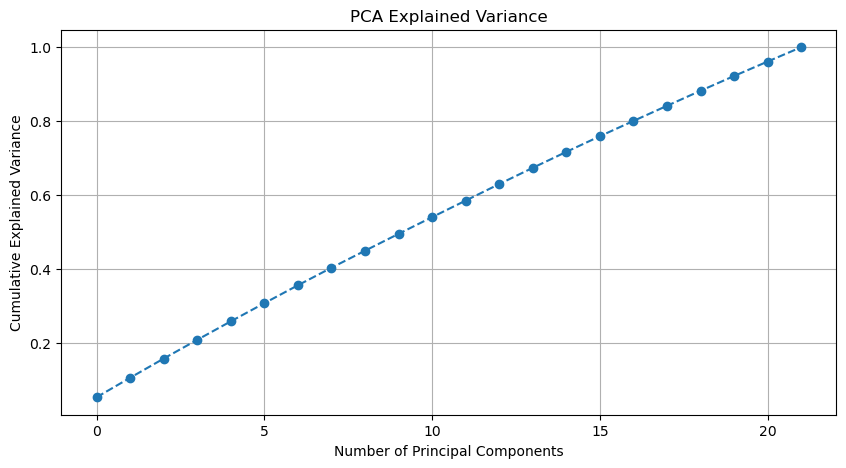

Number of components to explain 90% variance: 20
Explained variance with 20 components: 0.9221489340494687


In [5]:
# Principal Component Analysis (PCA)
# libraries needed to build and run the model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Removes Diagnosis from the dataset
X = Alzheimers.drop(columns=['Diagnosis'])
# standardizes the features
# needed because the PCA is sensitive to the scale of variables
X = StandardScaler().fit_transform(X)

# applies PCA on all components for analysis
pca = PCA()
X_pca = pca.fit_transform(X)

# plot configuration for explained variance per variable
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# analysis to configure the number of components needed to explain at least 90% of the variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to explain 90% variance: {num_components}")

# runs new PCA on components needed to explain 90% of the variance
pca_final = PCA(n_components=num_components) 
principal_components = pca_final.fit_transform(X)

# outputs the actual amount of variance explained by the components 
# has to be at least 90%
print(f"Explained variance with {num_components} components: {sum(pca_final.explained_variance_ratio_)}")

In [6]:
# Random Forest Classification Model 
# libraries needed to build and run the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# splitting the data into a 80/20 training test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# random forest is trained w/ 200 trees
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# labels for the test set are predicted
y_pred = rf.predict(X_test)

# evaluates the model
# provides: accuracy, precision, recall, f-1 score, and support
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7023255813953488
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.88      0.79       277
           1       0.63      0.39      0.48       153

    accuracy                           0.70       430
   macro avg       0.68      0.63      0.64       430
weighted avg       0.69      0.70      0.68       430



In [7]:
# Applying Synthetic Minority Oversampling Technique (SMOTE) to the Random Forest Classification
# used to correct the class imbalance in the Random Forest Classifier
# library needed to create the SMOTE
from imblearn.over_sampling import SMOTE

# oversampling for training class distribution balancing 
# needed to balance class 1 (those with Alzheimer's)
smote = SMOTE(random_state=42)
# balanced dataset
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# splitting the data into a 80/20 training test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Random Forest retraining
rf.fit(X_train, y_train)

# reevaluates the model
# provides: accuracy, precision, recall, f-1 score, and support
y_pred_smote = rf.predict(X_test)
print("Accuracy after SMOTE:", accuracy_score(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))


Accuracy after SMOTE: 0.7302158273381295
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       273
           1       0.73      0.76      0.74       283

    accuracy                           0.73       556
   macro avg       0.73      0.73      0.73       556
weighted avg       0.73      0.73      0.73       556



In [8]:
# XGBoost Classifier
# might be needed to run the code 
#!pip install xgboost
# libraries needed to build and run the model
from xgboost import XGBClassifier

# training the model on SMOTE-balanced training dataset
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)

# label prediction for test data
# model performance evaluation 
# provides: accuracy, precision, recall, f-1 score, and support
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.7212230215827338
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.68      0.70       273
           1       0.71      0.76      0.74       283

    accuracy                           0.72       556
   macro avg       0.72      0.72      0.72       556
weighted avg       0.72      0.72      0.72       556



In [9]:
# XGBoost with GridSearchCV (after feature engineering)
# GridSearchCV tests different hyperparameter combinations to select the best based on how they perform
from sklearn.model_selection import GridSearchCV

# set hyperparameter grid
# will test all combinations of n_estimators, learning_rate, max_depth, and subsample
# n_estimators = number of trees
# learning_rate = step size (smaller = slower, more accurate)
# max_depth = tree depth (deeper = more complex, but potential for overfit)
# subsample = data usage per tree
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1]
}

# grid search set up
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# search running and model fitting
grid_search.fit(X_train, y_train)

# extracts best model
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

# model performance evaluation 
# provides: accuracy, precision, recall, f-1 score, and support
print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_best_xgb))



Fitting 3 folds for each of 54 candidates, totalling 162 fits
Tuned XGBoost Accuracy: 0.7410071942446043
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73       273
           1       0.73      0.78      0.76       283

    accuracy                           0.74       556
   macro avg       0.74      0.74      0.74       556
weighted avg       0.74      0.74      0.74       556



In [10]:
# Stacked Model
# libraries with the stacking tools
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# set base learner model
# learn independently and next level pass predictions 
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=300, learning_rate=0.05, random_state=42))
]

# creating the stacked model
# combines strengths of both base learning models 
stacked_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# train base models from the training data and model the predictions they make
stacked_model.fit(X_train, y_train)
y_pred_stack = stacked_model.predict(X_test)

# model performance evaluation 
# provides: accuracy, precision, recall, f-1 score, and support
print("Stacked Model Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Classification Report:\n", classification_report(y_test, y_pred_stack))


Stacked Model Accuracy: 0.7320143884892086
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73       273
           1       0.74      0.74      0.74       283

    accuracy                           0.73       556
   macro avg       0.73      0.73      0.73       556
weighted avg       0.73      0.73      0.73       556



In [11]:
#XGBoost Test + Neural Network + Ensemble Model Learning
# might be needed to run the code 
#!pip install tensorflow
#!pip show tensorflow
#!pip install --upgrade tensorflow
# libraries needed to build and run the models
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import accuracy_score

# split the data into training, validation, and test sets
# this dataset is split into a 70/30 training test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# this is splitting the 30 of the training split in half (15/15 for each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# training the XGBoost Model
xgb_model = XGBClassifier().fit(X_train, y_train)

# setting and training the Neural Network Model
# sigmoid function activation utilized for binary classification
# ADAM optimizer and binary cross-entropy loss are used for compiling 
nn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# model performance evaluation for the XGBoost Test Accuracy
# provides: accuracy, precision, recall, f-1 score, and support
xgb_preds = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Test Accuracy: {xgb_acc}")

# model performance evaluation for the Neural Network
# provides: accuracy, precision, recall, f-1 score, and support
nn_preds = (nn_model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to class labels
nn_acc = accuracy_score(y_test, nn_preds)
print(f"Neural Network Test Accuracy: {nn_acc}")


# predictions made for both the XGBoost model and the Neural Network model
# looks at Class 1 (those with Alzheimer's probabilities 
xgb_probs = xgb_model.predict_proba(X_test)[:, 1] 
nn_probs = nn_model.predict(X_test)[:, 0] 

# averaging the prediction probabilities
final_probs = (xgb_probs + nn_probs) / 2  

# prediction probabilities conversion to class labels 
final_preds = (final_probs > 0.5).astype(int)

# model performance evaluation for the Ensemble Model
# provides: accuracy, precision, recall, f-1 score, and support
ensemble_acc = accuracy_score(y_test, final_preds)
print(f"Ensemble Model Test Accuracy: {ensemble_acc}")


XGBoost Test Accuracy: 0.6563467492260062
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Neural Network Test Accuracy: 0.6811145510835913
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Ensemble Model Test Accuracy: 0.6780185758513931


In [12]:
# XGBoost and Neural Network Classification AUS-ROC 
# libraries needed to build and run the model
from sklearn.metrics import classification_report

# XGBoost probability predictions
# model performance evaluation for the Ensemble Model
# provides: accuracy, precision, recall, f-1 score, and support
xgb_preds = xgb_model.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))

# Neural Network probability predictions
# model performance evaluation for the Ensemble Model
# provides: accuracy, precision, recall, f-1 score, and support
nn_probs = nn_model.predict(X_test)
nn_preds = (nn_probs > 0.5).astype(int) 
print("Neural Network Classification Report:\n", classification_report(y_test, nn_preds))

# library needed for the Area Under the Curve  (AUC) of the Receiver Operating Characteristic (ROC)
# measures how well the model can differentiate between class 1 and class 0 (those with and without Alzheimer's)
from sklearn.metrics import roc_auc_score

# Get probability scores
# retrieving probability prediction scores
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]  
nn_probs = nn_model.predict(X_test).flatten()

# calculating the AUC-ROC scores for the XGBoost and Neural Network models
xgb_auc = roc_auc_score(y_test, xgb_probs)
nn_auc = roc_auc_score(y_test, nn_probs)

print(f"XGBoost AUC-ROC Score: {xgb_auc:.4f}")
print(f"Neural Network AUC-ROC Score: {nn_auc:.4f}")


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.78      0.76       221
           1       0.45      0.38      0.41       102

    accuracy                           0.66       323
   macro avg       0.59      0.58      0.58       323
weighted avg       0.64      0.66      0.65       323

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76       221
           1       0.50      0.53      0.51       102

    accuracy                           0.68       323
   macro avg       0.64      0.64      0.64       323
weighted avg       0.69      0.68      0.68       323

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
XGBoost AUC-ROC Score: 0.7222
Neural Network AUC-ROC Score: 0.6927


C:\Users\madis\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:15:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                      Feature  Importance
18             CognitiveScore    0.123942
16  DifficultyCompletingTasks    0.062185
11                 HeadInjury    0.058070
15         PersonalityChanges    0.052324
2                   Ethnicity    0.048122
1                      Gender    0.044833
19              MetabolicRisk    0.043985
17              Forgetfulness    0.042794
12           CholesterolTotal    0.042268
0                         Age    0.041743
20          Cholesterol_Ratio    0.041738
21                   BP_Ratio    0.041539
8                SleepQuality    0.041521
5          AlcoholConsumption    0.039059
3              EducationLevel    0.038037
9     FamilyHistoryAlzheimers    0.037948
6            PhysicalActivity    0.037529
13                  Confusion    0.037353
7                 DietQuality    0.036944
10                 Depression    0.035263
14             Disorientation    0.026590
4                     Smoking    0.026213


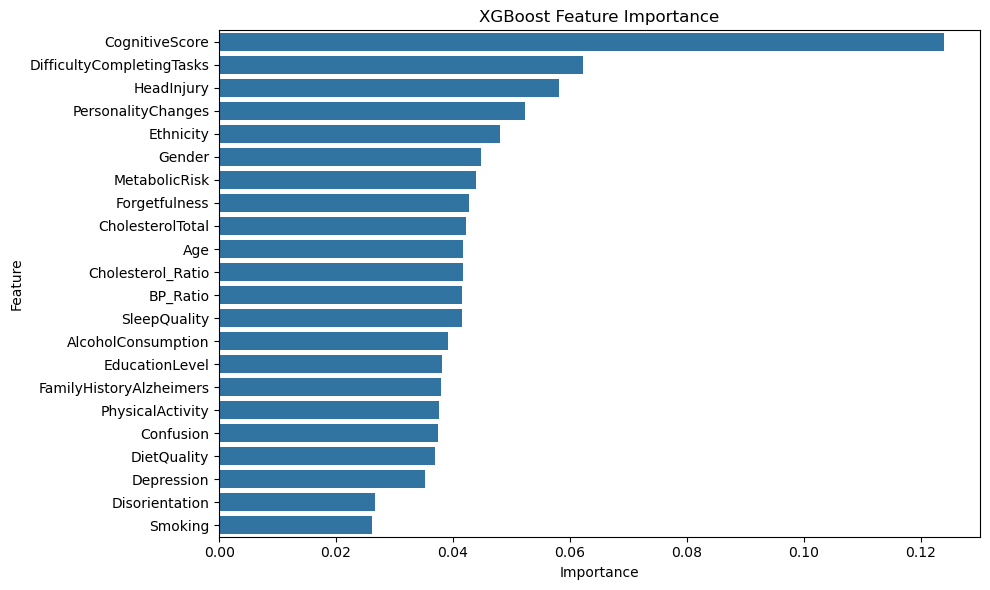

In [16]:
# libraries needed to build and run the model
import pandas as pd
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# splitting into the feature and target
# everything except for diagnosis
X = Alzheimers.drop(columns=['Diagnosis'])  # Feature set without the target variable 
y = Alzheimers['Diagnosis']  # Target variable

# splitting the data into a training test split
# maintains the same class distribution as the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# SMOTE application to training data 
# address class imbalance pre-training
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# training the XGBoost classifier 
# addresses class imbalance by giving more weight to the minority class
# trained on original data, not SMOTE trained data 
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# extracts important features
# sorts them in order of importance and displays them for analysis
importance = xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

# plot configurations 
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'])
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


In [22]:
# Classification and AUC-ROC score 
# library for building and running the model
from sklearn.metrics import classification_report, roc_auc_score

# parses out features that have an importance score > 0.04
important_features = importance_df[importance_df['Importance'] > 0.04]['Feature']

# new training and testing sets with only the parsed important features
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

# XGBoost model is retrained on important feature data 
xgb_model_reduced = XGBClassifier()
xgb_model_reduced.fit(X_train_important, y_train)

# model performance evaluation
# provides: accuracy, precision, recall, f-1 score, and support
xgb_preds_reduced = xgb_model_reduced.predict(X_test_important)
print(f"Accuracy with important features: {accuracy_score(y_test, xgb_preds_reduced)}")
print(classification_report(y_test, xgb_preds_reduced))

# calculation for the AUC-ROC score
xgb_probs_reduced = xgb_model_reduced.predict_proba(X_test_important)[:, 1]
print(f"AUC-ROC: {roc_auc_score(y_test, xgb_probs_reduced)}")

Accuracy with important features: 0.7007434944237918
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       348
           1       0.59      0.49      0.54       190

    accuracy                           0.70       538
   macro avg       0.67      0.65      0.66       538
weighted avg       0.69      0.70      0.69       538

AUC-ROC: 0.7243042952208105


In [19]:
# Best Hyperparameters Search
# library needed for systematic search of best hyperparameters
from sklearn.model_selection import GridSearchCV

# defined grid of parameters to be searched
# all combinations of factors are tested
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1], # manages tree contribution (lower = more slower/conversative learning)
    'max_depth': [3, 5, 7], #tree depth (manages model complexity)
    'n_estimators': [100, 200, 300] # number of trees
}

# intializing and running the grid search
grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_important, y_train)

# gives best hyperparameters and accuracy score from cross-validation of the accuracies 
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best accuracy: 0.7225313924196681
